*The last time this was run was sometime was some version before v0.16.0. It for sure breaks with 0.17.0*

# Firing vs. stimulation frequency for different irradiance and expression levels

Here we'll replicate figure 4 of Foutz et al., 2012, relating firing rate to stimulation frequency for (a) a range of irradiances and (b) a range of channel densities. Stimulation is a train of 5-ms pulses.

Original figure:

<img src="foutz12_4_original.jpg" alt="Foutz et al. 2012 Figure 4" height="300"/>
<!-- ![Foutz et al., 2012 Figure 4](foutz12_4_original.jpg) | ![Replication of Foutz et al., 2012 Figure 4](foutz12_4_replicated.svg) -->

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from brian2 import np
import brian2 as b2

# matplotlib.style.use(['seaborn', 'seaborn-notebook', 'dark_background'])
matplotlib.style.use(["seaborn-v0_8-paper"])
matplotlib.rcParams["font.sans-serif"] = "Open Sans"
matplotlib.rcParams["svg.fonttype"] = "none"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# We can run all the simulations at once using 5 neurons
# the 1.2*Irr0_thres, 1*rho condition is repeated in the two subpanels
from opto_val import lif, adex, Iopto_gain_from_factor
from brian2 import SpikeMonitor, Network, StateMonitor, prefs
import cleo
from cleo import CLSimulator
from cleo import opto

prefs.codegen.target = "numpy"


def make_ngs(n):
    return [
        lif(n, "LIF_simple"),
        lif(n, "LIF_Markov"),
        adex(n, "AdEx_simple"),
        adex(n, "AdEx_Markov"),
    ]


ngs = make_ngs(5)
spike_mons = {}
from cleo.coords import assign_coords_rand_rect_prism

for ng in ngs:
    spike_mons[ng.name] = SpikeMonitor(ng, record=True)
    # distance of 1 mm
    assign_coords_rand_rect_prism(ng, xlim=(0, 0), ylim=(0, 0), zlim=(1, 1))

net = Network(*ngs, *spike_mons.values())
sim = CLSimulator(net)

simple_opto_gain_factor = 15

sopsin = ProportionalCurrentOpsin(
    I_per_Irr=Iopto_gain_from_factor(simple_opto_gain_factor),
)
mopsin = chr2_4s()
# need separate fiber for each neuron group (to set Irr0 individually)
fibers = {}
for i, ng in enumerate(ngs):
    fiber = cleo.light.Light(light_model=cleo.light.fiber473nm(), name=f"fiber{i}")
    sim.inject(fiber, ng)
    fibers[ng] = fiber
# neurons 1, 3, 4 (0-index) for varying channel density
rho_rel = [1, 1, 1, 1.5, 0.75]
sim.inject(sopsin, ngs[0], ngs[2], rho_rel=rho_rel)
sim.inject(mopsin, ngs[1], ngs[3], rho_rel=rho_rel)
# neurons 0, 1, and 2 will have varying irradiance
Irr0_ratio = [1.4, 1.2, 1, 1.2, 1.2]
lor = cleo.registry.registry_for_sim(sim)
for light_prop_syn in lor.light_prop_syns.values():
    light_prop_syn.T *= Irr0_ratio * len(ngs)
    print(light_prop_syn.T)

sim.network.store()

<light_prop_ProportionalCurrentOpsin_LIF_simple.T: array([0.0031451, 0.0026958, 0.0022465, 0.0026958, 0.0026958, 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       ])>
<light_prop_ProportionalCurrentOpsin_AdEx_simple.T: array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.0031451, 0.0026958,
       0.0022465, 0.0026958, 0.0026958, 0.       , 0.       , 0.       ,
       0.       , 0.       ])>
<light_prop_ChR2_LIF_Markov.T: array([0.       , 0.       , 0.       , 0.       , 0.       , 0.0031451,
       0.0026958, 0.0022465, 0.0026958, 0.0026958, 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       ])>
<light_prop_ChR2_AdEx_Markov.T: array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.  

We need irradiance thresholds for each neuron type for a 5 ms pulse:

In [3]:
from opto_val import get_Irr0_thres

Irr0_thres = {ng.name: {} for ng in ngs}
for ng in make_ngs(1):
    simple_opto = "simple" in ng.name
    Irr0_thres[ng.name] = get_Irr0_thres(
        [5],
        1,
        ng,
        simple_opto=simple_opto,
        gain_factor=simple_opto_gain_factor,
        precision=0.1,
        target="numpy",
    )[0]
Irr0_thres

INFO       No numerical integration method specified for group 'LIF_simple', using method 'exact' (took 0.26s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'LIF_Markov', using method 'exact' (took 0.02s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'syn_ChR2_LIF_Markov', using method 'euler' (took 0.03s, trying other methods took 0.09s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'AdEx_simple', using method 'euler' (took 0.01s, trying other methods took 0.06s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'AdEx_Markov', using method 'euler' (took 0.01s, trying other methods took 0.02s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'syn_ChR2_AdEx_Markov', using method 'euler' (took 0.01s,

{'LIF_simple': 134.2010498046875,
 'LIF_Markov': 22.8118896484375,
 'AdEx_simple': 164.8712158203125,
 'AdEx_Markov': 29.0679931640625}

We prepare a pandas dataframe to store data in tidy format:

In [4]:
import pandas as pd

df = pd.DataFrame(
    columns=["name", "pulse_rate", "firing_rate", "Irr0/Irr0_thres", "rho_rel"]
)
df

,name,pulse_rate,firing_rate,Irr0/Irr0_thres,rho_rel


Next we load the original data for comparison. First, from the top panel, showing data for different irradiance levels.

In [5]:
wpd_data_irr = pd.read_csv("data/foutz12_4a_wpd.csv")
wpd_data_irr.head()

,1.4,Unnamed: 1,1.2,Unnamed: 3,1,Unnamed: 5
0,X,Y,X,Y,X,Y
1,0.2440316822846853,0.685016323314187,0.5926483712628183,0.8609141055949578,0.7669567157518813,0.15732297647190308
2,97.3337795626952,97.07700101317123,90.71006247211064,90.21698750422155,10.702532351628733,0.5091185410334447
3,105.70058009817045,101.65034335247103,99.77409638554217,94.0867387143983,25.518741633199454,3.323483057525607
4,114.93892235609103,103.9370145221209,119.47093931280678,97.95648992457504,31.445225345827737,5.258358662614


In [6]:
for i_col in [0, 2, 4]:
    for i_row in range(1, len(wpd_data_irr)):
        if pd.isna(wpd_data_irr.iloc[i_row, i_col]):
            continue
        df.loc[len(df)] = [
            "MCHH_Markov",  # name
            wpd_data_irr.iloc[i_row, i_col],  # pulse rate
            wpd_data_irr.iloc[i_row, i_col + 1],  # firing rate
            wpd_data_irr.columns[i_col],  # Irr0/Irr0_thres
            1,  # rho_rel
        ]
df = df.astype(
    {
        "pulse_rate": float,
        "firing_rate": float,
        "Irr0/Irr0_thres": float,
        "rho_rel": float,
    }
)
df.tail()

,name,pulse_rate,firing_rate,Irr0/Irr0_thres,rho_rel
39,MCHH_Markov,139.167782,91.975965,1.0,1.0
40,MCHH_Markov,150.672133,96.549308,1.0,1.0
41,MCHH_Markov,156.075692,97.077001,1.0,1.0
42,MCHH_Markov,176.644076,101.298548,1.0,1.0
43,MCHH_Markov,199.827086,105.871890,1.0,1.0


Now for the bottom panel with varying levels of opsin expression:

In [7]:
wpd_data_exp = pd.read_csv("data/foutz12_4b_wpd.csv")
wpd_data_exp.head()

,1.5,Unnamed: 1,1,Unnamed: 3,0.75,Unnamed: 5
0,X,Y,X,Y,X,Y
1,0.18040727560301661,0.06011857180919833,0.07743508633190288,0.06011857180919833,0.48932384341637913,0.06011857180919833
2,89.76621194147889,89.98817612576605,90.2810728878345,89.98817612576605,20.36295637274287,20.148214761524116
3,100.37234743640441,100.29243272049027,99.8574864900488,93.943345323741,29.527481217872705,21.605382360778037
4,110.46362198497432,105.18435251798559,120.14300777645975,97.89851452171592,37.147423223935704,27.329969357847034


In [8]:
for i_col in [0, 2, 4]:
    for i_row in range(1, len(wpd_data_exp)):
        if pd.isna(wpd_data_exp.iloc[i_row, i_col]):
            continue
        df.loc[len(df)] = [
            "MCHH_Markov",  # name
            wpd_data_exp.iloc[i_row, i_col],  # pulse rate
            wpd_data_exp.iloc[i_row, i_col + 1],  # firing rate
            1.2,  # Irr0/Irr0_thres
            wpd_data_exp.columns[i_col],  # rho_rel
        ]
df.tail()

,name,pulse_rate,firing_rate,Irr0/Irr0_thres,rho_rel
79,MCHH_Markov,161.33188348490842,98.00259792166267,1.2,0.75
80,MCHH_Markov,170.0845195729538,99.8760991207034,1.2,0.75
81,MCHH_Markov,179.8668775537103,104.1435185185185,1.2,0.75
82,MCHH_Markov,190.16409648082248,106.32926991739942,1.2,0.75
83,MCHH_Markov,199.63753789376568,105.91293631761255,1.2,0.75


In [10]:
from math import sin, tau
from brian2 import Hz, ms, second, defaultclock

pulse_rates = np.linspace(0.1, 200, 20)

rerun_sim = False
rerun_sim = input("(Re-)run simulations? Will take 4 mins. (y/N) ").lower() == "y"


class PulseController(cleo.ioproc.LatencyIOProcessor):
    def process(self, state, t_samp_ms):
        t = t_samp_ms * ms
        # use sine curve to define pulse train
        # need threshold above which sine will be over for 5 ms at a time
        t_peak = 1 / (4 * pulse_rate)  # where sine curve peaks
        t_pulse_start = t_peak - 2.5 * ms  # 2.5 ms to either side of peak -> 5 ms pulse
        sin_thres = sin(tau * pulse_rate * t_pulse_start)
        stim_on = int(np.sin(tau * self.pulse_rate * t) >= sin_thres)
        out = {}
        for ng, fiber in fibers.items():
            out[fiber.name] = stim_on * Irr0_thres[ng.name]
        return out, t_samp_ms


ctrl = PulseController(sample_period_ms=defaultclock.dt / ms)
sim.set_io_processor(ctrl)

if rerun_sim:
    for pulse_rate in pulse_rates * Hz:
        sim.reset()
        ctrl.pulse_rate = pulse_rate
        # for (opsin, ng), light_prop_syn in lor.light_prop_syns.items():
        #     eq = f"Irr0_pre = {Irr0_thres[ng.name]}*mwatt/mm2 * int(sin({tau}*pulse_rate*t) >= sin_thres)"
        #     light_prop_syn.run_regularly(eq)
        duration_s = 0.4
        sim.run(duration_s * second)
        for ng_name, mon in spike_mons.items():
            df = pd.concat(
                [
                    df,
                    pd.DataFrame(
                        {
                            "name": ng_name,
                            "pulse_rate": pulse_rate / Hz,
                            # need to wrap VariableView in array to copy
                            "firing_rate": np.array(mon.count_) / duration_s,
                            "Irr0/Irr0_thres": Irr0_ratio,
                            "rho_rel": rho_rel,
                        }
                    ),
                ]
            )

    df.to_csv("data/pr_fr_irr_exp.csv", index=False)
df = pd.read_csv("data/pr_fr_irr_exp.csv")
df.tail()

INFO       No numerical integration method specified for group 'AdEx_Markov', using method 'euler' (took 0.01s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'AdEx_simple', using method 'euler' (took 0.01s, trying other methods took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'LIF_Markov', using method 'exact' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'LIF_simple', using method 'exact' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'syn_ChR2_AdEx_Markov', using method 'euler' (took 0.01s, trying other methods took 0.02s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'syn_ChR2_LIF_Markov', using method 'euler' (took 0.01s,

,name,pulse_rate,firing_rate,Irr0/Irr0_thres,rho_rel
479,AdEx_Markov,200.0,115.0,1.4,1.00
480,AdEx_Markov,200.0,105.0,1.2,1.00
481,AdEx_Markov,200.0,92.5,1.0,1.00
482,AdEx_Markov,200.0,160.0,1.2,1.50
483,AdEx_Markov,200.0,77.5,1.2,0.75


In [12]:
# make sure each Irr0 and T are set properly
for (opsin, ng), light_prop_syn in lor.light_prop_syns.items():
    print(light_prop_syn.Irr0_pre)
    print(light_prop_syn.T)

<light_prop_ProportionalCurrentOpsin_LIF_simple.Irr0_pre: array([134201.04980469, 134201.04980469, 134201.04980469, 134201.04980469,
       134201.04980469,  22811.88964844,  22811.88964844,  22811.88964844,
        22811.88964844,  22811.88964844, 164871.21582031, 164871.21582031,
       164871.21582031, 164871.21582031, 164871.21582031,  29067.99316406,
        29067.99316406,  29067.99316406,  29067.99316406,  29067.99316406]) * watt / (meter ** 2)>
<light_prop_ProportionalCurrentOpsin_LIF_simple.T: array([0.0031451, 0.0026958, 0.0022465, 0.0026958, 0.0026958, 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       ])>
<light_prop_ProportionalCurrentOpsin_AdEx_simple.Irr0_pre: array([134201.04980469, 134201.04980469, 134201.04980469, 134201.04980469,
       134201.04980469,  22811.88964844,  22811.88964844,  22811.88964844,
        22811.88964844,  22811.88

WARNING    /tmp/ipykernel_729/3517261148.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=data[df.rho_rel == 1],
 [py.warnings]


WARNING    /tmp/ipykernel_729/3517261148.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=data[df['Irr0/Irr0_thres']== 1.2],
 [py.warnings]
WARNING    /tmp/ipykernel_729/3517261148.py:35: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles=g.legend.legendHandles,
 [py.warnings]


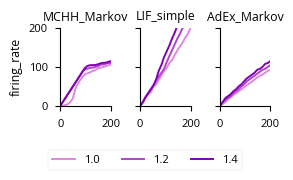

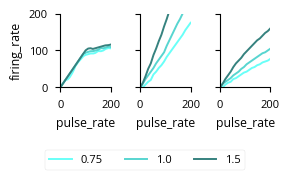

In [14]:
def plot_fr_2panel(data, palette1, palette2):
    kwargs = {
        "kind": "line",
        "col": "name",
        "x": "pulse_rate",
        "y": "firing_rate",
        # "height": 1.6,
        # "aspect": 0.7,
        # "palette": palette,
        "legend": True,
        # "facet_kws": {'legend_out': True},
    }
    g_irr = sns.relplot(
        data=data[df.rho_rel == 1],
        hue="Irr0/Irr0_thres",
        palette=palette1,
        **kwargs,
    )
    g_exp = sns.relplot(
        data=data[df["Irr0/Irr0_thres"] == 1.2],
        hue="rho_rel",
        palette=palette2,
        **kwargs,
    )

    g_irr.set_axis_labels(x_var="")
    g_irr.set_titles(col_template="{col_name}")
    # g_irr.set_xticklabels([])
    g_exp.set_titles(col_template="")

    for g in (g_irr, g_exp):
        g.set(xlim=(0, pulse_rates[-1]), ylim=(0, pulse_rates[-1]))
        g.legend.remove()
        g.fig.legend(
            handles=g.legend.legendHandles,
            loc="upper center",
            bbox_to_anchor=(0.5, 0),
            # title="title",
            ncol=3,
        )
        g.fig.set_figwidth(3.0)
        g.fig.set_figheight(1.5)
        # g.add_legend(ncol=3)
        g.fig.tight_layout()
    return g_irr, g_exp


g_irr, g_exp = plot_fr_2panel(
    df[~df.name.str.contains("LIF_Markov|AdEx_simple", regex=True)],
    palette1="blend:#df87e1,#8000b4",
    palette2="blend:#69fff8,#36827F",
    # palette="blend:#DDDDDD,black",
)
g_irr.fig.savefig("img/fig/opto_pr_fr_irr.svg", bbox_inches="tight")
g_exp.fig.savefig("img/fig/opto_pr_fr_exp.svg", bbox_inches="tight")

WARNING    /tmp/ipykernel_729/3517261148.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=data[df.rho_rel == 1],
 [py.warnings]


WARNING    /tmp/ipykernel_729/3517261148.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=data[df['Irr0/Irr0_thres']== 1.2],
 [py.warnings]
WARNING    /tmp/ipykernel_729/3517261148.py:35: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles=g.legend.legendHandles,
 [py.warnings]


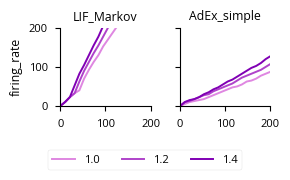

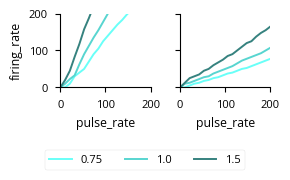

In [16]:
g_irr, g_exp = plot_fr_2panel(
    df[df.name.str.contains("LIF_Markov|AdEx_simple", regex=True)],
    palette1="blend:#df87e1,#8000b4",
    palette2="blend:#69fff8,#36827F",
)
g_irr.fig.savefig("img/fig/opto_pr_fr_irr_supp.svg")
g_exp.fig.savefig("img/fig/opto_pr_fr_exp_supp.svg")